In [13]:
import pandas as pd

df = pd.read_csv("/home/hp/results/MOUSE/distance_analysis_data.csv")
print("Columns in the CSV:", df.columns.tolist())

Columns in the CSV: ['Mutation', 'Mean_dG_star', 'Mean_dG0', 'dG_star_raw', 'dG0_raw', 'Level', 'name', 'sec49_distance', 'ca_distance']


Arial font not found. For best PLOS ONE compliance, consider:
- Linux: sudo apt-get install ttf-mscorefonts-installer
- Mac: Arial should be pre-installed
- Windows: Arial should be pre-installed
- Alternative: Install Liberation Sans or use default system font
Using fallback font: DejaVu Sans
Found 17 mutations that occur at multiple levels


/tmp/ipykernel_245172/4250314130.py:380: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


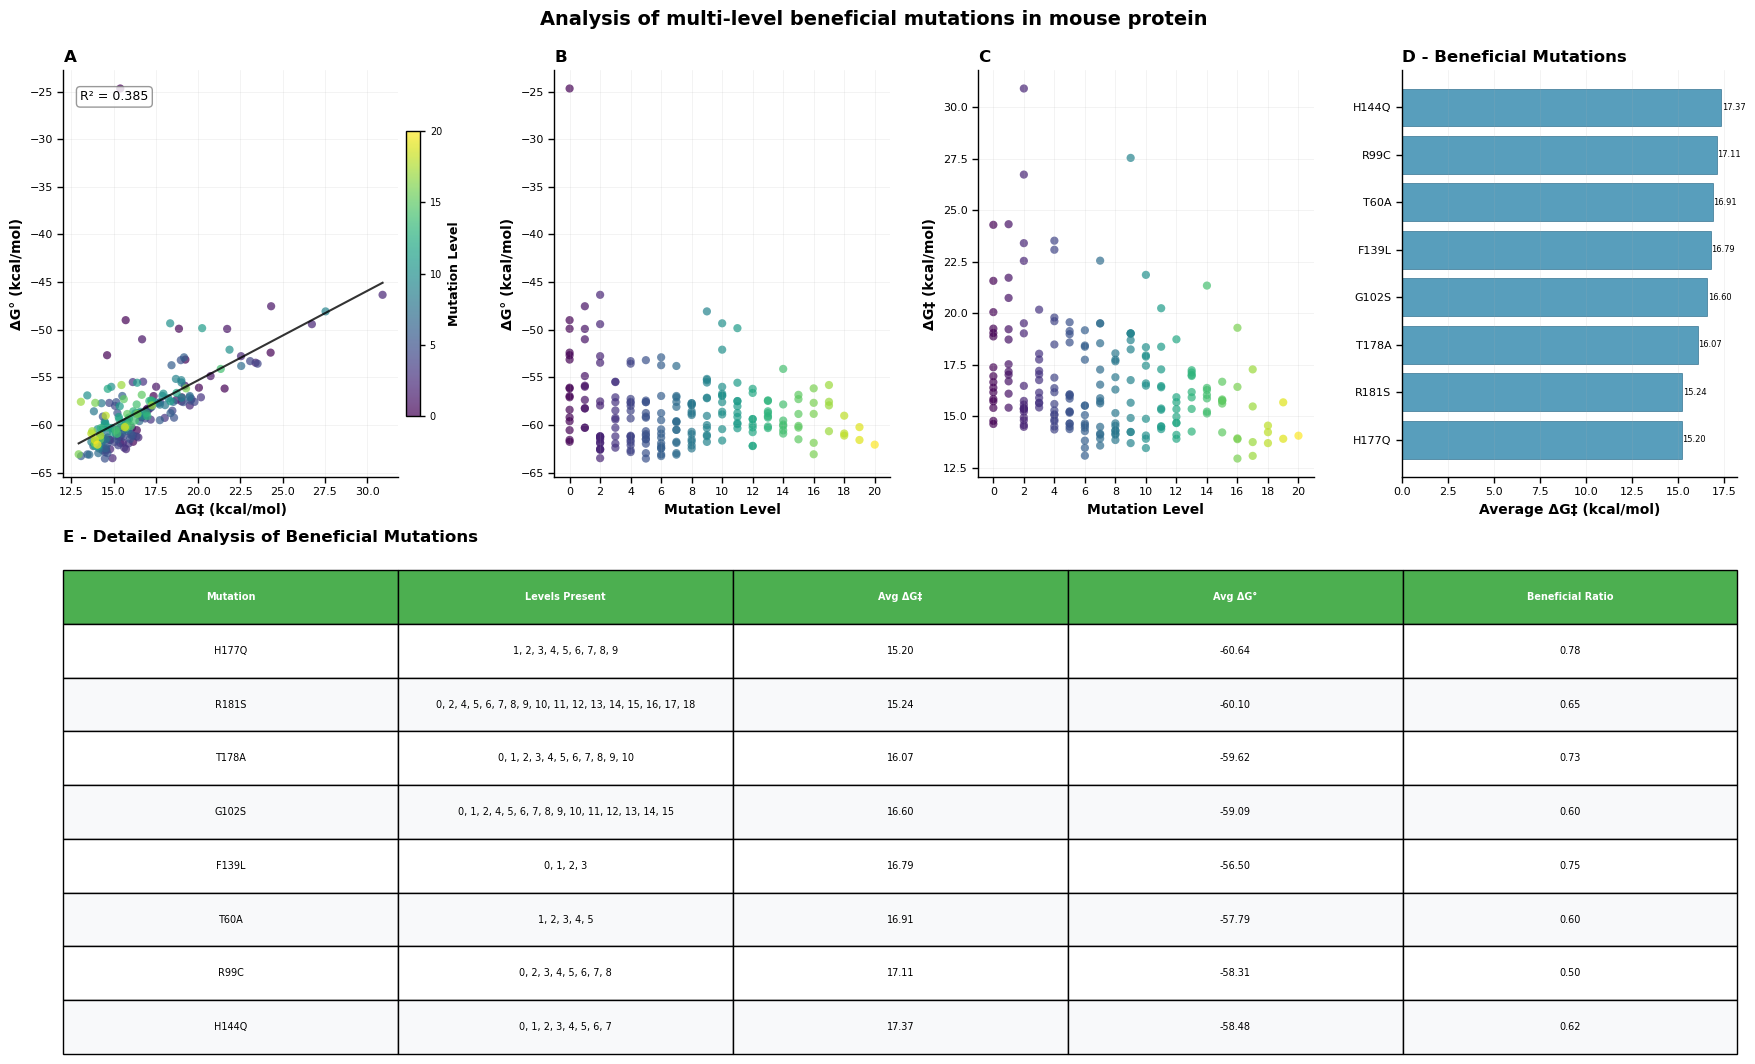


BENEFICIAL MUTATION ANALYSIS
Total mutations analyzed: 205
Mutations appearing at multiple levels: 17
Beneficial mutations (consistently lower ΔG‡): 8

Top beneficial mutations:
 1. H177Q
    Levels: [1, 2, 3, 4, 5, 6, 7, 8, 9]
    Avg ΔG‡: 15.20 kcal/mol
    Beneficial ratio: 0.78
 2. R181S
    Levels: [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    Avg ΔG‡: 15.24 kcal/mol
    Beneficial ratio: 0.65
 3. T178A
    Levels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    Avg ΔG‡: 16.07 kcal/mol
    Beneficial ratio: 0.73
 4. G102S
    Levels: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    Avg ΔG‡: 16.60 kcal/mol
    Beneficial ratio: 0.60
 5. F139L
    Levels: [0, 1, 2, 3]
    Avg ΔG‡: 16.79 kcal/mol
    Beneficial ratio: 0.75
 6. T60A
    Levels: [1, 2, 3, 4, 5]
    Avg ΔG‡: 16.91 kcal/mol
    Beneficial ratio: 0.60
 7. R99C
    Levels: [0, 2, 3, 4, 5, 6, 7, 8]
    Avg ΔG‡: 17.11 kcal/mol
    Beneficial ratio: 0.50
 8. H144Q
    Levels: [0, 1, 2, 3, 4, 5, 6, 7]
    Avg

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.font_manager as fm
from scipy import stats

def normalize_data(data):
    """
    Normalize data to 0-1 range using min-max normalization
    Replaces sklearn's MinMaxScaler
    
    Parameters:
    -----------
    data : numpy.ndarray
        Data to normalize
    
    Returns:
    --------
    numpy.ndarray
        Normalized data with values between 0 and 1
    """
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    
    # Avoid division by zero
    data_range = data_max - data_min
    data_range[data_range == 0] = 1
    
    return (data - data_min) / data_range

def check_arial_font():
    """Check if Arial font is available and provide installation guidance"""
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    arial_variants = ['Arial', 'Arial Unicode MS', 'Arial Black']
    
    arial_available = any(font in available_fonts for font in arial_variants)
    
    if not arial_available:
        print("Arial font not found. For best PLOS ONE compliance, consider:")
        print("- Linux: sudo apt-get install ttf-mscorefonts-installer")
        print("- Mac: Arial should be pre-installed")
        print("- Windows: Arial should be pre-installed")
        print("- Alternative: Install Liberation Sans or use default system font")
        return False
    else:
        print("Arial font is available")
        return True

def setup_plos_style():
    """Configure matplotlib for PLOS ONE journal standards"""
    # Check Arial availability first
    arial_available = check_arial_font()
    
    # Set font family with fallbacks
    if arial_available:
        rcParams['font.family'] = 'Arial'
    else:
        # Use best available alternative
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        fallback_fonts = ['DejaVu Sans', 'Liberation Sans', 'Helvetica', 'sans-serif']
        
        for font in fallback_fonts:
            if font in available_fonts:
                rcParams['font.family'] = font
                print(f"Using fallback font: {font}")
                break
        else:
            rcParams['font.family'] = 'sans-serif'
            print("Using default sans-serif font")
    
    # PLOS ONE compliant font sizes
    rcParams['font.size'] = 8
    rcParams['axes.labelsize'] = 10
    rcParams['axes.titlesize'] = 12
    rcParams['xtick.labelsize'] = 8
    rcParams['ytick.labelsize'] = 8
    rcParams['legend.fontsize'] = 8
    rcParams['figure.titlesize'] = 14
    rcParams['axes.linewidth'] = 1.0
    rcParams['xtick.major.width'] = 1.0
    rcParams['ytick.major.width'] = 1.0
    rcParams['xtick.minor.width'] = 0.5
    rcParams['ytick.minor.width'] = 0.5
    rcParams['savefig.dpi'] = 300
    rcParams['savefig.bbox'] = 'tight'
    rcParams['savefig.pad_inches'] = 0.1

def analyze_beneficial_mutations(df_sorted):
    """
    Analyze beneficial mutations - those that occur across multiple levels with consistently lower ΔG‡
    
    Parameters:
    -----------
    df_sorted : pandas.DataFrame
        Sorted dataframe with mutation data
        
    Returns:
    --------
    dict : Dictionary containing beneficial mutation analysis
    """
    results = {}
    
    # Find mutations that occur at multiple levels
    mutation_level_counts = df_sorted.groupby('mutation')['Level'].nunique()
    multi_level_mutations = mutation_level_counts[mutation_level_counts > 1].index.tolist()
    
    print(f"Found {len(multi_level_mutations)} mutations that occur at multiple levels")
    
    # For mutations at multiple levels, check if they consistently have lower ΔG‡
    beneficial_mutations = []
    mutation_analysis = {}
    
    # Calculate median ΔG‡ for each level to use as reference
    level_medians = df_sorted.groupby('Level')['dg_star'].median()
    
    for mutation in multi_level_mutations:
        mutation_data = df_sorted[df_sorted['mutation'] == mutation].copy()
        
        # Check if this mutation has lower ΔG‡ than median at each level it appears
        beneficial_at_levels = []
        total_levels = []
        
        for _, row in mutation_data.iterrows():
            level = row['Level']
            dg_star = row['dg_star']
            level_median = level_medians[level]
            
            total_levels.append(level)
            if dg_star < level_median:  # Lower (more favorable) ΔG‡
                beneficial_at_levels.append(level)
        
        # Consider beneficial if it's better than median at majority of levels where it appears
        beneficial_ratio = len(beneficial_at_levels) / len(total_levels)
        
        mutation_analysis[mutation] = {
            'levels_present': sorted(total_levels),
            'levels_beneficial': sorted(beneficial_at_levels),
            'beneficial_ratio': beneficial_ratio,
            'avg_dg_star': mutation_data['dg_star'].mean(),
            'avg_dg0': mutation_data['dg0'].mean(),
            'level_count': len(total_levels)
        }
        
        # Consider it beneficial if it's better than median at ≥50% of levels
        if beneficial_ratio >= 0.5:
            beneficial_mutations.append(mutation)
    
    # Sort beneficial mutations by average ΔG‡ (most favorable first)
    beneficial_mutations.sort(key=lambda x: mutation_analysis[x]['avg_dg_star'])
    
    results = {
        'multi_level_mutations': multi_level_mutations,
        'beneficial_mutations': beneficial_mutations,
        'mutation_analysis': mutation_analysis,
        'level_medians': level_medians
    }
    
    return results

def create_plos_analysis(csv_path):
    """
    Create PLOS ONE compliant figure for mutation analysis
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file containing mutation data
    """
    
    # Setup PLOS ONE styling
    setup_plos_style()
    
    # Load and validate data
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {csv_path}")
    
    # Standardize column names
    column_mapping = {
        'Mean_dG_star': 'dg_star',
        'Mean_dG0': 'dg0', 
        'Mutation': 'mutation',
        'mean_dg_star': 'dg_star',
        'mean_dg0': 'dg0'
    }
    
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df = df.rename(columns={old_name: new_name})
    
    # Validate required columns
    required_cols = {'dg_star', 'dg0', 'mutation', 'Level'}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Clean and sort data
    df = df.dropna(subset=list(required_cols))
    df_sorted = df.sort_values('Level').reset_index(drop=True)
    
    # Analyze beneficial mutations
    beneficial_analysis = analyze_beneficial_mutations(df_sorted)
    
    # Create figure with PLOS ONE compliant layout
    fig = plt.figure(figsize=(18, 12), facecolor='white')
    
    # Create clean grid layout for PLOS ONE
    gs = fig.add_gridspec(3, 4, height_ratios=[2.5, 1.2, 1.2], width_ratios=[1.2, 1, 1, 1],
                         hspace=0.35, wspace=0.25, left=0.05, right=0.98, 
                         top=0.90, bottom=0.08)
    
    # Main plots
    ax1 = fig.add_subplot(gs[0, 0])  # LFER plot
    ax2 = fig.add_subplot(gs[0, 1])  # Level vs dG0
    ax3 = fig.add_subplot(gs[0, 2])  # Level vs dG_star
    ax4 = fig.add_subplot(gs[0, 3])  # Bar plot of beneficial mutations
    ax5 = fig.add_subplot(gs[1:, :])  # Table of beneficial mutations
    
    # Panel A: Linear Free Energy Relationship (LFER) - Clean PLOS style
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_sorted['dg_star'], df_sorted['dg0'])
    
    # Ensure levels are integers
    df_sorted['Level'] = df_sorted['Level'].astype(int)
    
    # Clean scatter plot for PLOS ONE
    scatter = ax1.scatter(df_sorted['dg_star'], df_sorted['dg0'],
                         c=df_sorted['Level'], s=35, alpha=0.7, 
                         edgecolors='none',
                         cmap='viridis', vmin=0, vmax=df_sorted['Level'].max())
    
    # Add colorbar with PLOS ONE styling
    cbar = plt.colorbar(scatter, ax=ax1, shrink=0.7, aspect=20, pad=0.02)
    cbar.set_label('Mutation Level', fontweight='bold', fontsize=9)
    cbar.ax.tick_params(labelsize=7)
    
    # Set discrete ticks for levels
    unique_levels = sorted(df_sorted['Level'].unique())
    if len(unique_levels) <= 10:
        cbar.set_ticks(unique_levels)
    else:
        step = 2 if len(unique_levels) <= 20 else 5
        cbar.set_ticks(range(0, max(unique_levels)+1, step))
    
    # Add LFER line with PLOS ONE styling
    x_range = np.array([df_sorted['dg_star'].min(), df_sorted['dg_star'].max()])
    y_pred = slope * x_range + intercept
    ax1.plot(x_range, y_pred, 'k-', alpha=0.8, linewidth=1.5)
    
    # Add R² annotation in clean format
    ax1.text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=ax1.transAxes,
             fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', 
             facecolor='white', alpha=0.8, edgecolor='gray'))
    
    ax1.set_xlabel('ΔG‡ (kcal/mol)', fontweight='bold', fontsize=10)
    ax1.set_ylabel('ΔG° (kcal/mol)', fontweight='bold', fontsize=10)
    ax1.set_title('A', fontweight='bold', loc='left', fontsize=12)
    ax1.grid(True, alpha=0.2, linewidth=0.5)
    
    # Panel B: Level vs ΔG° - Clean PLOS style
    scatter2 = ax2.scatter(df_sorted['Level'], df_sorted['dg0'],
                          c=df_sorted['Level'], s=35, alpha=0.7,
                          edgecolors='none',
                          cmap='viridis', vmin=0, vmax=df_sorted['Level'].max())
    
    ax2.set_xticks(range(int(df_sorted['Level'].min()), int(df_sorted['Level'].max()) + 1, 2))
    ax2.set_xlabel('Mutation Level', fontweight='bold', fontsize=10)
    ax2.set_ylabel('ΔG° (kcal/mol)', fontweight='bold', fontsize=10)
    ax2.set_title('B', fontweight='bold', loc='left', fontsize=12)
    ax2.grid(True, alpha=0.2, linewidth=0.5)
    
    # Panel C: Level vs ΔG‡ - Clean PLOS style
    scatter3 = ax3.scatter(df_sorted['Level'], df_sorted['dg_star'],
                          c=df_sorted['Level'], s=35, alpha=0.7,
                          edgecolors='none',
                          cmap='viridis', vmin=0, vmax=df_sorted['Level'].max())
    
    ax3.set_xticks(range(int(df_sorted['Level'].min()), int(df_sorted['Level'].max()) + 1, 2))
    ax3.set_xlabel('Mutation Level', fontweight='bold', fontsize=10)
    ax3.set_ylabel('ΔG‡ (kcal/mol)', fontweight='bold', fontsize=10)
    ax3.set_title('C', fontweight='bold', loc='left', fontsize=12)
    ax3.grid(True, alpha=0.2, linewidth=0.5)
    
    # Panel D: Bar plot of beneficial mutations
    beneficial_mutations = beneficial_analysis['beneficial_mutations']
    mutation_analysis = beneficial_analysis['mutation_analysis']
    
    if len(beneficial_mutations) > 0:
        # Get average ΔG‡ values for beneficial mutations
        avg_dg_star_values = [mutation_analysis[mut]['avg_dg_star'] for mut in beneficial_mutations]
        
        # Create bar plot - limit to top 15 for readability
        display_mutations = beneficial_mutations[:15] if len(beneficial_mutations) > 15 else beneficial_mutations
        display_values = avg_dg_star_values[:15] if len(avg_dg_star_values) > 15 else avg_dg_star_values
        
        bars = ax4.barh(range(len(display_mutations)), display_values, 
                       color='#2E86AB', alpha=0.8, edgecolor='#1B5E7F', linewidth=0.5)
        
        ax4.set_yticks(range(len(display_mutations)))
        ax4.set_yticklabels([mut[:12] + '...' if len(mut) > 12 else mut for mut in display_mutations], 
                           fontsize=7)
        ax4.set_xlabel('Average ΔG‡ (kcal/mol)', fontweight='bold', fontsize=10)
        ax4.set_title('D - Beneficial Mutations', fontweight='bold', loc='left', fontsize=12)
        ax4.grid(True, alpha=0.2, axis='x', linewidth=0.5)
        
        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, display_values)):
            width = bar.get_width()
            ax4.text(width + 0.01*abs(max(display_values) - min(display_values)), 
                    bar.get_y() + bar.get_height()/2,
                    f'{value:.2f}', ha='left', va='center', fontsize=6)
    else:
        ax4.text(0.5, 0.5, 'No beneficial mutations found', 
                transform=ax4.transAxes, ha='center', va='center', fontsize=10)
        ax4.set_title('D - Beneficial Mutations', fontweight='bold', loc='left', fontsize=12)
    
    # Panel E: Table of beneficial mutations
    ax5.axis('off')
    ax5.set_title('E - Detailed Analysis of Beneficial Mutations', fontweight='bold', 
                  loc='left', fontsize=12, pad=20)
    
    if len(beneficial_mutations) > 0:
        # Create table data
        table_data = []
        headers = ['Mutation', 'Levels Present', 'Avg ΔG‡', 'Avg ΔG°', 'Beneficial Ratio']
        
        for mut in beneficial_mutations[:20]:  # Show top 20
            analysis = mutation_analysis[mut]
            levels_str = ', '.join(map(str, analysis['levels_present']))
            table_data.append([
                mut[:15] + '...' if len(mut) > 15 else mut,
                levels_str,
                f"{analysis['avg_dg_star']:.2f}",
                f"{analysis['avg_dg0']:.2f}",
                f"{analysis['beneficial_ratio']:.2f}"
            ])
        
        # Create table
        table = ax5.table(cellText=table_data, colLabels=headers,
                         cellLoc='center', loc='center',
                         bbox=[0.0, 0.0, 1.0, 1.0])
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(7)
        table.scale(1, 1.5)
        
        # Color header
        for i in range(len(headers)):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Alternate row colors
        for i in range(1, len(table_data) + 1):
            for j in range(len(headers)):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#f8f9fa')
                else:
                    table[(i, j)].set_facecolor('white')
    else:
        ax5.text(0.5, 0.5, 'No beneficial mutations found\n(No mutations appear at multiple levels with consistently lower ΔG‡)', 
                transform=ax5.transAxes, ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#ffebee', alpha=0.8))
    
    # Clean up scatter plots for PLOS ONE style
    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.tick_params(axis='both', which='major', labelsize=8, width=1, length=4)
        ax.tick_params(axis='both', which='minor', labelsize=6, width=0.5, length=2)
    
    # Add figure title
    fig.suptitle('Analysis of multi-level beneficial mutations in mouse protein', 
                 fontsize=14, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n" + "="*100)
    print("BENEFICIAL MUTATION ANALYSIS")
    print("="*100)
    print(f"Total mutations analyzed: {len(df_sorted)}")
    print(f"Mutations appearing at multiple levels: {len(beneficial_analysis['multi_level_mutations'])}")
    print(f"Beneficial mutations (consistently lower ΔG‡): {len(beneficial_mutations)}")
    
    if len(beneficial_mutations) > 0:
        print(f"\nTop beneficial mutations:")
        for i, mut in enumerate(beneficial_mutations[:10], 1):
            analysis = mutation_analysis[mut]
            print(f"{i:2d}. {mut}")
            print(f"    Levels: {analysis['levels_present']}")
            print(f"    Avg ΔG‡: {analysis['avg_dg_star']:.2f} kcal/mol")
            print(f"    Beneficial ratio: {analysis['beneficial_ratio']:.2f}")
    
    return fig, (ax1, ax2, ax3, ax4, ax5), beneficial_analysis

def create_figure_legend():
    """
    Create a comprehensive figure legend following PLOS ONE guidelines
    """
    legend_text = """
    Figure 1. Analysis of multi-level beneficial mutations in mouse protein 
    
    (A) Linear Free Energy Relationship (LFER) between ΔG‡ and ΔG°. Points are 
    colored by mutation level as shown in the colorbar. Black line shows LFER 
    with correlation coefficient.
    
    (B,C) Mutation level effects on ΔG° and ΔG‡ respectively. Points are colored 
    by level using the same color scale as panel A.
    
    (D) Bar plot showing average ΔG‡ values for beneficial mutations. Beneficial 
    mutations are defined as those appearing at multiple levels with consistently 
    lower ΔG‡ values compared to the median at each level.
    
    (E) Detailed table of beneficial mutations showing levels where they appear, 
    average thermodynamic parameters, and beneficial ratio (fraction of levels 
    where ΔG‡ is below median).
    
    Energy values in kcal/mol. Beneficial ratio ≥0.5 indicates mutation is 
    favorable at majority of levels where it appears.
    """
    return legend_text

def calculate_correlations(df_sorted):
    """Calculate correlation statistics between variables"""
    correlations = {}
    
    # Level vs thermodynamic parameters
    level_dg0_corr, level_dg0_p = stats.pearsonr(df_sorted['Level'], df_sorted['dg0'])
    level_dg_star_corr, level_dg_star_p = stats.pearsonr(df_sorted['Level'], df_sorted['dg_star'])
    
    # LFER correlation
    lfer_corr, lfer_p = stats.pearsonr(df_sorted['dg_star'], df_sorted['dg0'])
    
    correlations = {
        'level_dg0': {'r': level_dg0_corr, 'p': level_dg0_p},
        'level_dg_star': {'r': level_dg_star_corr, 'p': level_dg_star_p},
        'lfer': {'r': lfer_corr, 'p': lfer_p}
    }
    
    return correlations

# Example usage with error handling
def main():
    """Main function to run the analysis"""
    csv_path = "/home/hp/results/MOUSE/distance_analysis_data.csv"
    
    try:
        fig, axes, beneficial_analysis = create_plos_analysis(csv_path)
        
        # Load data for additional statistics
        df = pd.read_csv(csv_path)
        
        # Standardize column names
        column_mapping = {
            'Mean_dG_star': 'dg_star',
            'Mean_dG0': 'dg0', 
            'Mutation': 'mutation',
            'mean_dg_star': 'dg_star',
            'mean_dg0': 'dg0'
        }
        
        for old_name, new_name in column_mapping.items():
            if old_name in df.columns:
                df = df.rename(columns={old_name: new_name})
        
        df = df.dropna(subset=['dg_star', 'dg0', 'mutation', 'Level'])
        df_sorted = df.sort_values('Level').reset_index(drop=True)
        
        # Calculate correlations
        correlations = calculate_correlations(df_sorted)
        
        # Print correlation statistics
        print("\n" + "="*60)
        print("CORRELATION ANALYSIS:")
        print("="*60)
        print(f"Level vs ΔG°: r = {correlations['level_dg0']['r']:.3f}, p = {correlations['level_dg0']['p']:.2e}")
        print(f"Level vs ΔG‡: r = {correlations['level_dg_star']['r']:.3f}, p = {correlations['level_dg_star']['p']:.2e}")
        print(f"LFER (ΔG‡ vs ΔG°): r = {correlations['lfer']['r']:.3f}, p = {correlations['lfer']['p']:.2e}")
        
        # Print legend for copy-paste into manuscript
        print("\n" + "="*60)
        print("FIGURE LEGEND FOR MANUSCRIPT:")
        print("="*60)
        print(create_figure_legend())
        
        # Print some basic statistics
        print(f"\nDataset summary:")
        print(f"Number of mutations: {len(df)}")
        if 'Level' in df.columns:
            print(f"Level range: {int(df['Level'].min())} - {int(df['Level'].max())}")
            print(f"Unique levels: {sorted(df['Level'].astype(int).unique())}")
        
    except Exception as e:
        print(f"Error creating figure: {e}")
        print("Please check your data file and column names.")

if __name__ == "__main__":
    main()